# Markovian model of swiss railways

In [1]:
import math
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm.notebook import trange, tqdm

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [3]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/Juli/data_clean_201807.pkl')

In [5]:
# Calculate dwell times
data['DWELL'] = (
    pd.to_datetime(data['ABFAHRTSZEIT'], format="%d.%m.%Y %H:%M") -
    pd.to_datetime(data['ANKUNFTSZEIT'], format="%d.%m.%Y %H:%M")).dt.total_seconds().fillna(0).astype(int)

In [6]:
# Collect features
features = []

In [7]:
# One feature per day
for day in tqdm(data['BETRIEBSTAG'].unique()):
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

In [8]:
# Example of one route
index = 0
features[index].loc[(features[index].FAHRT_BEZEICHNER == '85:11:10:002')]

BETRIEBSTAG FAHRT_BEZEICHNER BETREIBER_ABK PRODUKT_ID LINIEN_ID LINIEN_TEXT  \
1  01.07.2018     85:11:10:002           SBB        Zug        10          EC   
2  01.07.2018     85:11:10:002           SBB        Zug        10          EC   
3  01.07.2018     85:11:10:002           SBB        Zug        10          EC   
4  01.07.2018     85:11:10:002           SBB        Zug        10          EC   
5  01.07.2018     85:11:10:002           SBB        Zug        10          EC   
6  01.07.2018     85:11:10:002           SBB        Zug        10          EC   

  VERKEHRSMITTEL_TEXT  ZUSATZFAHRT_TF  FAELLT_AUS_TF HALTESTELLEN_NAME  \
1                  EC           False          False           Chiasso   
2                  EC           False          False            Lugano   
3                  EC           False          False        Bellinzona   
4                  EC           False          False       Arth-Goldau   
5                  EC           False          False               Zug   
6                  EC           False          False         Zürich HB   

       ANKUNFTSZEIT          AN_PROGNOSE AN_PROGNOSE_STATUS      ABFAHRTSZEIT  \
1  01.07.2018 19:10  01.07.2018 19:16:00           PROGNOSE  01.07.2018 19:15   
2  01.07.2018 19:40  01.07.2018 19:40:17               REAL  01.07.2018 19:42   
3  01.07.2018 20:10  01.07.2018 20:15:30               REAL  01.07.2018 20:13   
4  01.07.2018 21:09  01.07.2018 21:09:36               REAL  01.07.2018 21:13   
5  01.07.2018 21:27  01.07.2018 21:27:37               REAL  01.07.2018 21:29   
6  01.07.2018 21:51  01.07.2018 21:52:43               REAL               NaN   

           AB_PROGNOSE AB_PROGNOSE_STATUS  DURCHFAHRT_TF  DWELL  
1  01.07.2018 19:21:17           PROGNOSE          False    300  
2  01.07.2018 19:45:06               REAL          False    120  
3  01.07.2018 20:17:48               REAL          False    180  
4  01.07.2018 21:13:59               REAL          False    240  
5  01.07.2018 21:30:09               REAL          False    120  
6                  NaN           PROGNOSE          False      0

## Model construction

In [9]:
# Collect starting vectors
initials = []
# Collect transition matrices
matrices = []
# Collect states
states = []

for feature in tqdm(features[0:7]):

    # Dictionary of stations
    dic = {'station': np.unique(feature['HALTESTELLEN_NAME'])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]

    # Initialize a n*1 initial start vector
    t = (n)
    Initial = pd.DataFrame(np.zeros(t))

    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))


    for route in tqdm(feature.FAHRT_BEZEICHNER.unique(),
                      desc=feature['BETRIEBSTAG'].unique()[0]):

        temp = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        # Sort routes by datetime of arrival
        temp = temp.sort_values(by='ABFAHRTSZEIT', ascending=True, na_position='last')

        # Calculate running times
        temp['RUNNING'] = (
            pd.to_datetime(temp['ANKUNFTSZEIT'].shift(-1), format="%d.%m.%Y %H:%M") -
            pd.to_datetime(temp['ABFAHRTSZEIT'], format="%d.%m.%Y %H:%M")
        ).dt.total_seconds().fillna(0).astype(int)

        # Check for sensor errors
        if any(temp['RUNNING'].values.ravel()<0):
            continue
            
        if any(temp['RUNNING'].values.ravel()<0):
            continue
        
        stops = temp['HALTESTELLEN_NAME']

        if len(stops) > 1:
            #print(temp[['AN_PROGNOSE', 'AB_PROGNOSE', 'DWELL', 'RUNNING']])

            # Start vector
            pos_i = stations.loc[stations['station'] == stops.iloc[0]].index[0]
            Initial.iloc[pos_i] += 1

            # Transition matrix
            for i in range(len(stops) - 1):
                pos1 = stations.loc[stations['station'] == stops.iloc[i]].index[0]
                pos2 = stations.loc[stations['station'] == stops.iloc[i + 1]].index[0]
                # Calculate dwell times
                dwell = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]['DWELL'].values[0]
                # Calculate running times
                running = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]['RUNNING'].values[0]                        

                # Add running times as self-loop
                matrix.iloc[pos1, pos2] += running
                # Add dwell times as self-loop
                matrix.iloc[pos1, pos1] += dwell
            dwell = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i+1]]['DWELL'].values[0]
            matrix.iloc[pos2, pos2] += dwell
                    
    # Fill in the vectors
    Initial_dist = Initial.div(Initial.sum(axis=0), axis=1)
    Initial_dist.columns = ['Prob']
    Initial_dist['Station'] = dic['station']
    initials.append(Initial_dist)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

In [10]:
# Check for negatives
for matrix in matrices:
    s = matrix.values.ravel()
    print(any(s<0))

True


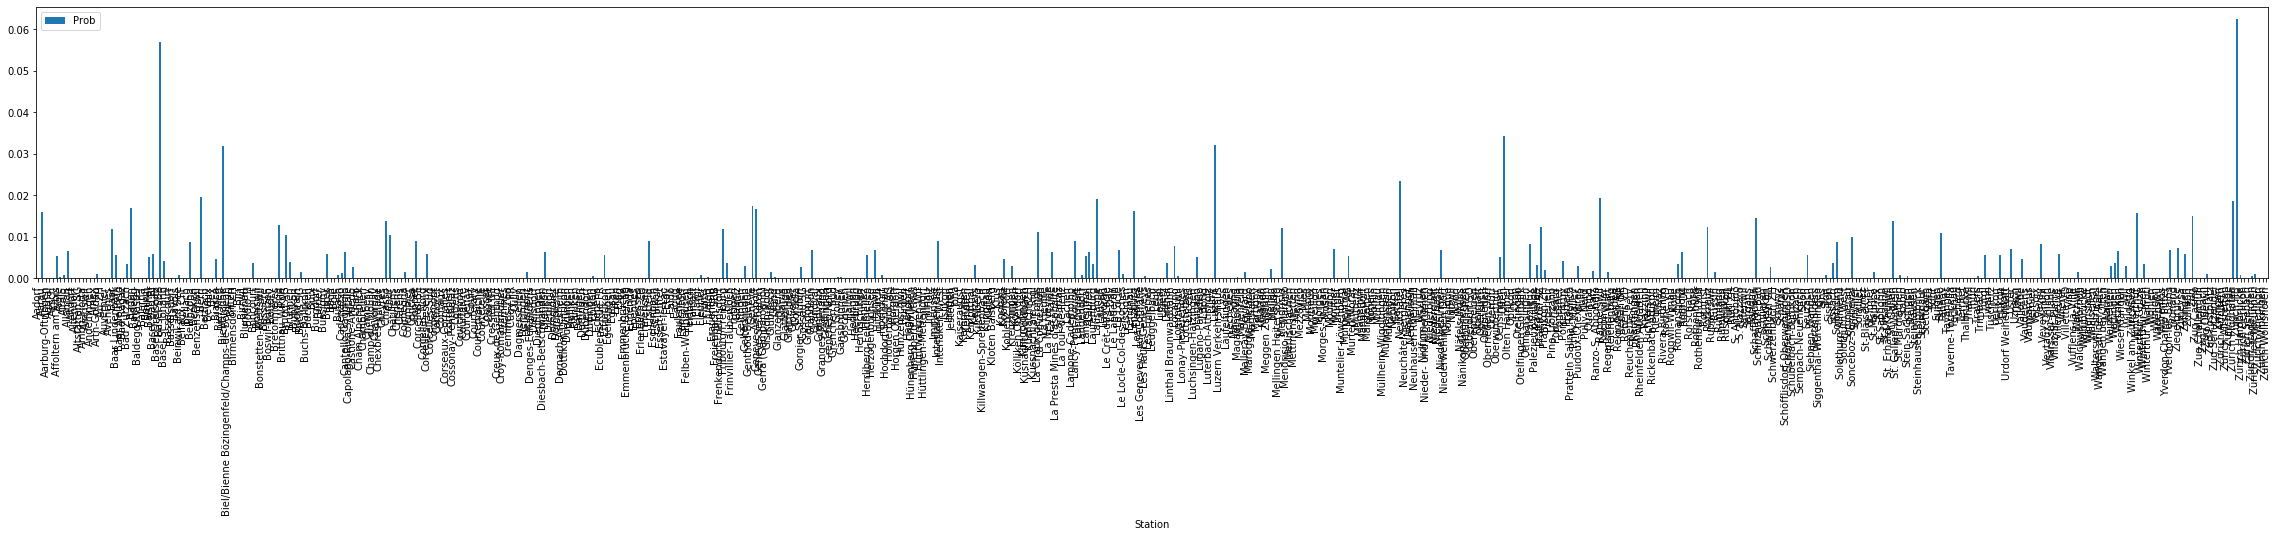

In [11]:
# The most frequent starting stations
for initial in initials:
    initial.plot.bar(x='Station', y='Prob', figsize=(40, 5))

In [35]:
# Make a deep copy of discrete matrices
TMs = []
for matrix in matrices:
    TM = matrix.copy(deep=True)
    TMs.append(TM)

In [36]:
# Now convert to probabilities
for i, TM in enumerate(TMs):
    eps = .001
    count = 0
    for row in TM.values:
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', states[i].iloc[count]['station'], count, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            print('Singularity at', states[i].iloc[count]['station'], count, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

In [14]:
for TM in TMs:
    s = TM.values.ravel()
    print(any(s<0), sum(s), round(sum(s)))

True 603.0000000000003 603.0


In [15]:
TM

Aadorf     Aarau  Aarburg-Oftringen  Aathal     Aesch  \
Index                                                                         
Aadorf                   0.2  0.000000                0.0     0.0  0.000000   
Aarau                    0.0  0.117102                0.0     0.0  0.000000   
Aarburg-Oftringen        0.0  0.000000                0.0     0.0  0.000000   
Aathal                   0.0  0.000000                0.0     0.0  0.000000   
Aesch                    0.0  0.000000                0.0     0.0  0.017986   
...                      ...       ...                ...     ...       ...   
Zürich Stadelhofen       0.0  0.000000                0.0     0.0  0.000000   
Zürich Tiefenbrunnen     0.0  0.000000                0.0     0.0  0.000000   
Zürich Wiedikon          0.0  0.000000                0.0     0.0  0.000000   
Zürich Wipkingen         0.0  0.000000                0.0     0.0  0.000000   
Zürich Wollishofen       0.0  0.000000                0.0     0.0  0.000000   

                      Affoltern am Albis  Aigle  Airolo  Allaman  Altdorf  \
Index                                                                       
Aadorf                               0.0    0.0     0.0      0.0      0.0   
Aarau                                0.0    0.0     0.0      0.0      0.0   
Aarburg-Oftringen                    0.0    0.0     0.0      0.0      0.0   
Aathal                               0.0    0.0     0.0      0.0      0.0   
Aesch                                0.0    0.0     0.0      0.0      0.0   
...                                  ...    ...     ...      ...      ...   
Zürich Stadelhofen                   0.0    0.0     0.0      0.0      0.0   
Zürich Tiefenbrunnen                 0.0    0.0     0.0      0.0      0.0   
Zürich Wiedikon                      0.0    0.0     0.0      0.0      0.0   
Zürich Wipkingen                     0.0    0.0     0.0      0.0      0.0   
Zürich Wollishofen                   0.0    0.0     0.0      0.0      0.0   

                      ...  Zürich Flughafen  Zürich HB  Zürich Hardbrücke  \
Index                 ...                                                   
Aadorf                ...               0.0   0.000000                0.0   
Aarau                 ...               0.0   0.155907                0.0   
Aarburg-Oftringen     ...               0.0   0.000000                0.0   
Aathal                ...               0.0   0.000000                0.0   
Aesch                 ...               0.0   0.000000                0.0   
...                   ...               ...        ...                ...   
Zürich Stadelhofen    ...               0.0   0.248576                0.0   
Zürich Tiefenbrunnen  ...               0.0   0.000000                0.0   
Zürich Wiedikon       ...               0.0   0.623596                0.0   
Zürich Wipkingen      ...               0.0   0.674931                0.0   
Zürich Wollishofen    ...               0.0   0.000000                0.0   

                      Zürich Oerlikon  Zürich Seebach  Zürich Stadelhofen  \
Index                                                                       
Aadorf                       0.000000             0.0            0.000000   
Aarau                        0.000000             0.0            0.000000   
Aarburg-Oftringen            0.000000             0.0            0.000000   
Aathal                       0.000000             0.0            0.000000   
Aesch                        0.000000             0.0            0.000000   
...                               ...             ...                 ...   
Zürich Stadelhofen           0.000000             0.0            0.181093   
Zürich Tiefenbrunnen         0.000000             0.0            0.431111   
Zürich Wiedikon              0.000000             0.0            0.000000   
Zürich Wipkingen             0.325069             0.0            0.000000   
Zürich Wollishofen           0.000000             0.0            0

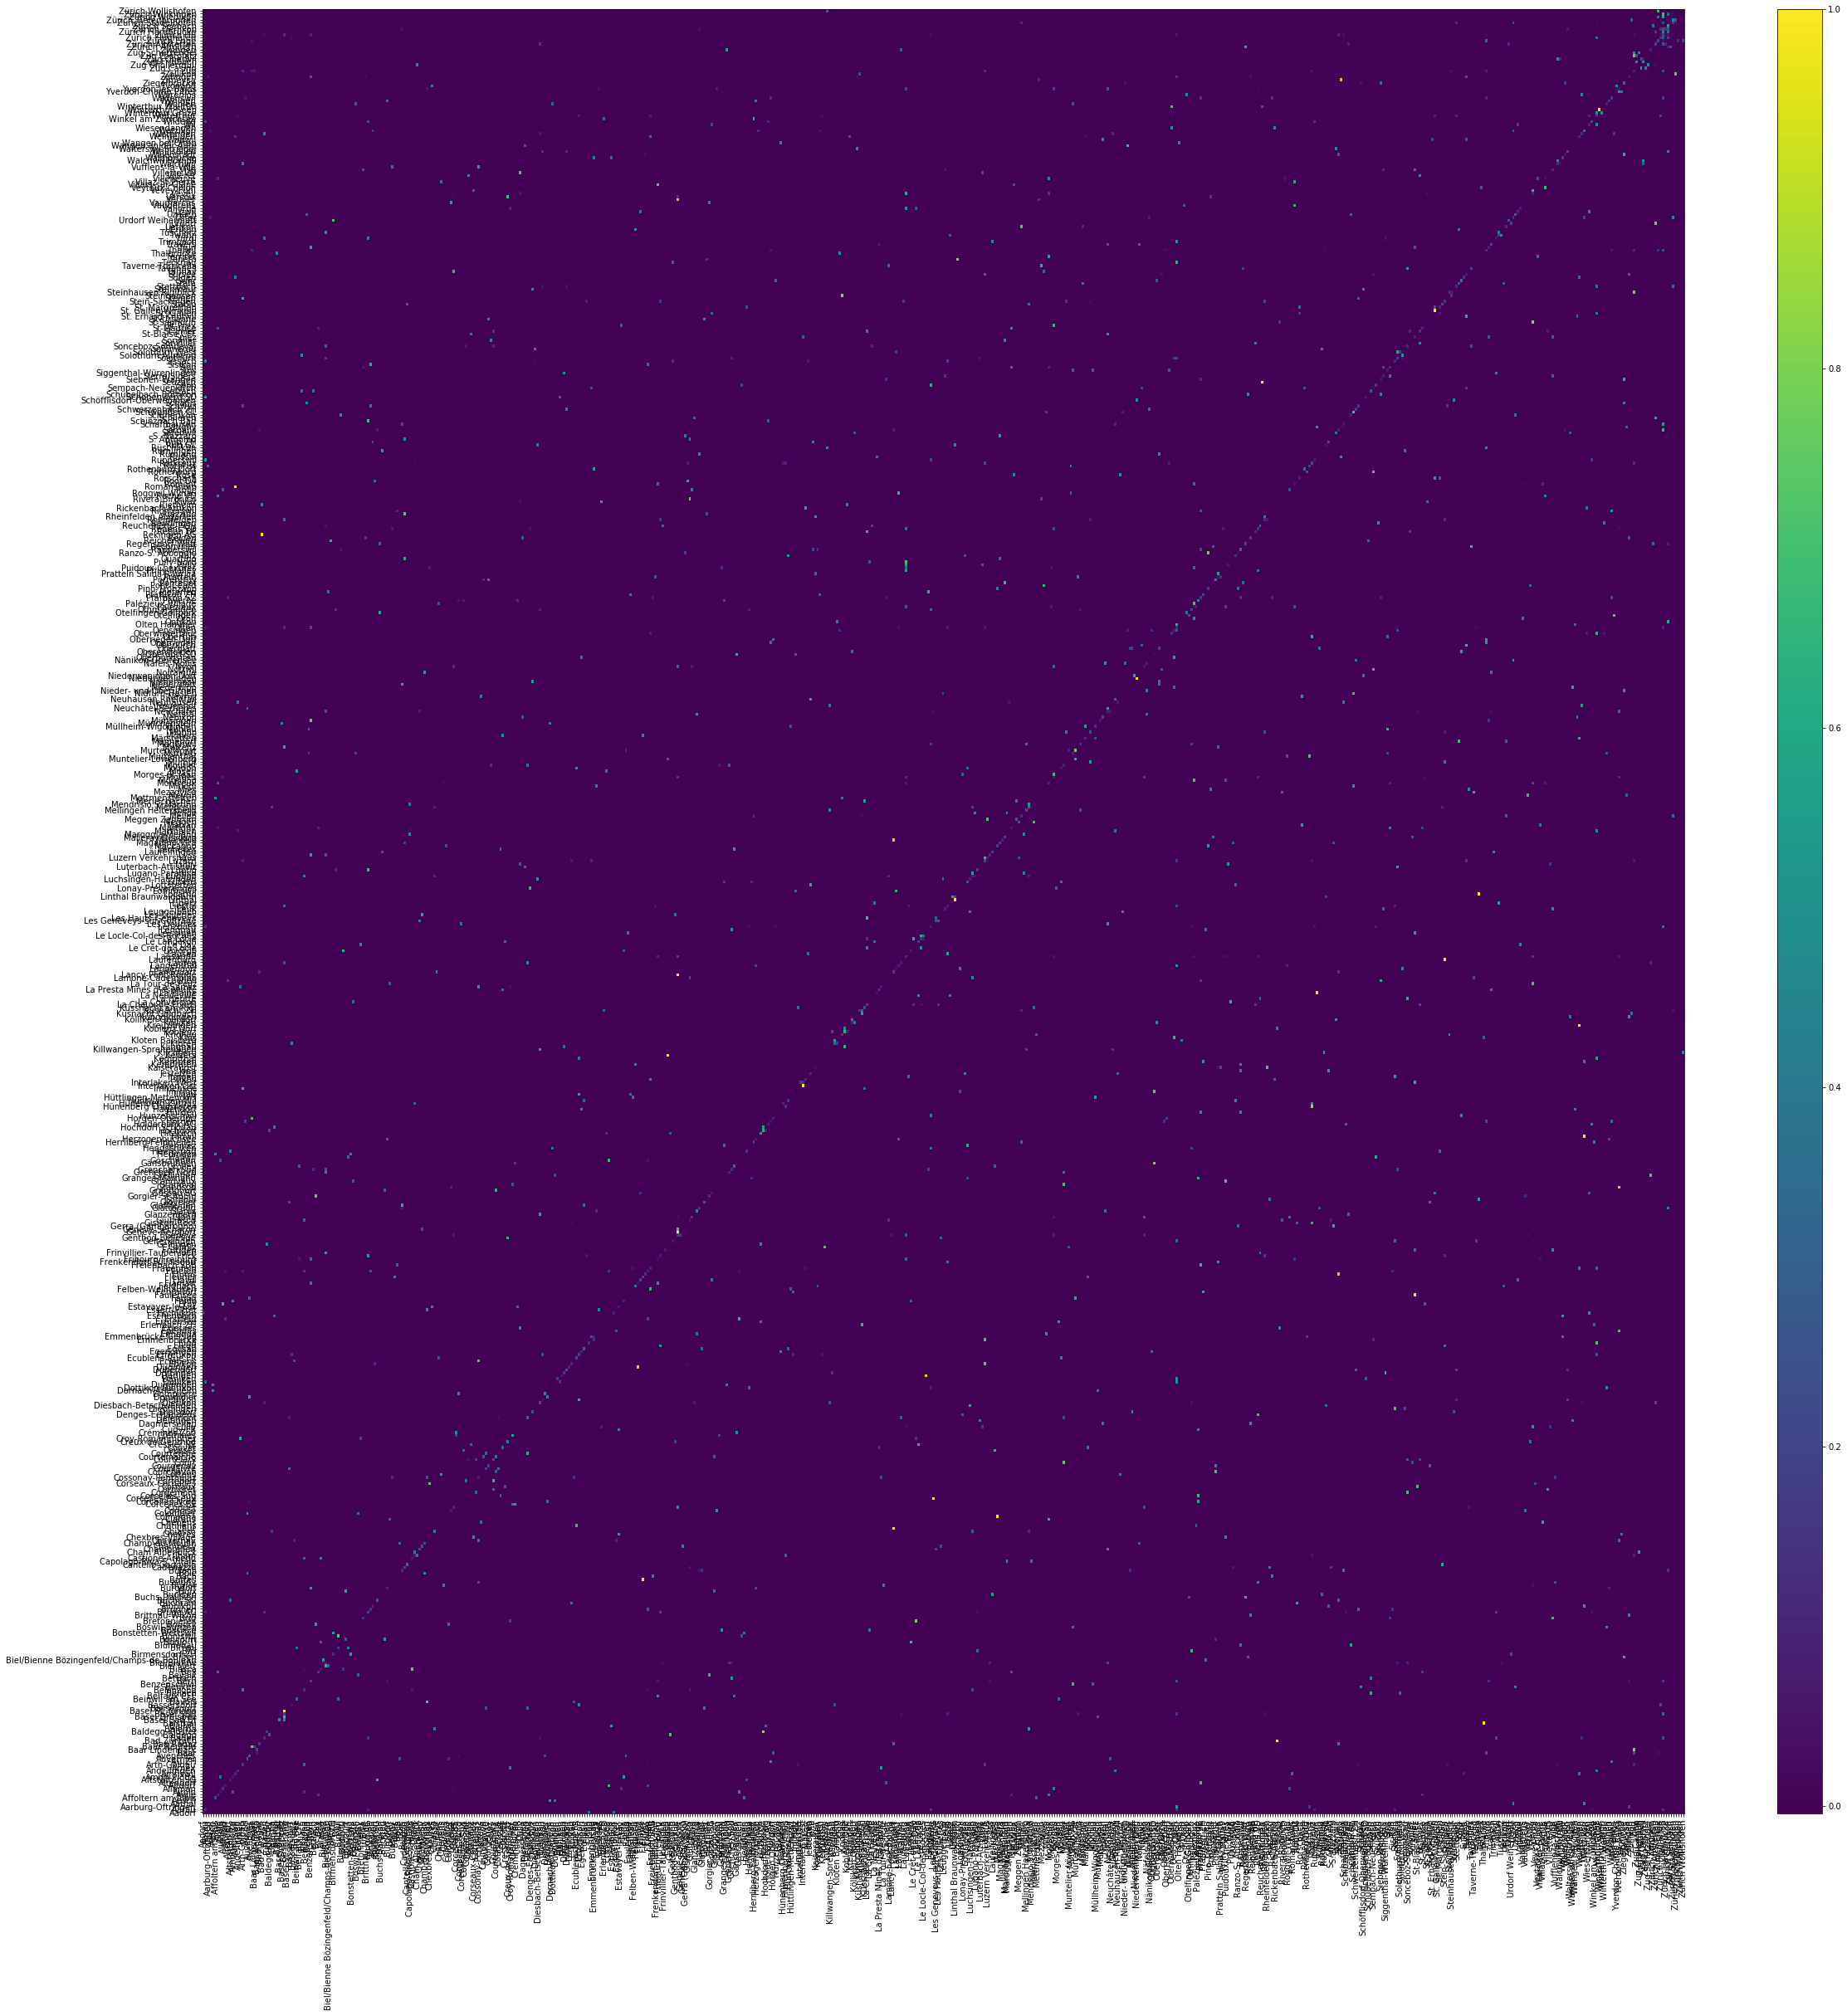

In [16]:
# Directed adjacency matrix
index = 0
TM = TMs[index]
plt.figure(figsize=(40, 40))
plt.pcolor(TM)
plt.yticks(np.arange(0.5, states[index].shape[0], 1), TM.index)
plt.xticks(np.arange(0.5, states[index].shape[0], 1), TM.columns, rotation='vertical')
plt.colorbar(aspect=40)
plt.show()

## Analysis

In [17]:
from scipy.linalg import norm
import time

In [18]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [33]:
# We run the power iteration for several times to see if there are some variations in the mixing time
mixing = []

for TM in TMs:
    n = 20
    Mixing_times_n_times = np.zeros((n, 1))
    for i in range(n):
        t, mixing_ = simulate_markov(TM, verbose='off')
        Mixing_times_n_times[i] = mixing_
    mixing.append(Mixing_times_n_times)

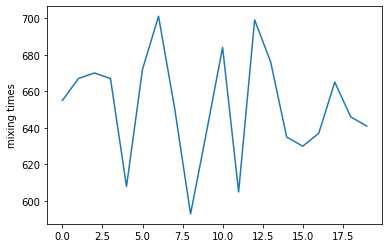

In [34]:
for mix in mixing:
    plt.plot(mix)
plt.ylabel('mixing times')
plt.show()

In [19]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [20]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

2440.74676874497 1.0


In [21]:
# Steady distribution of stations
steady_states = []

for i, initial in enumerate(initials):
    Steady_dist = initial
    Steady_dist['Pi'] = pi_list[i]
    steady_states.append(Steady_dist)

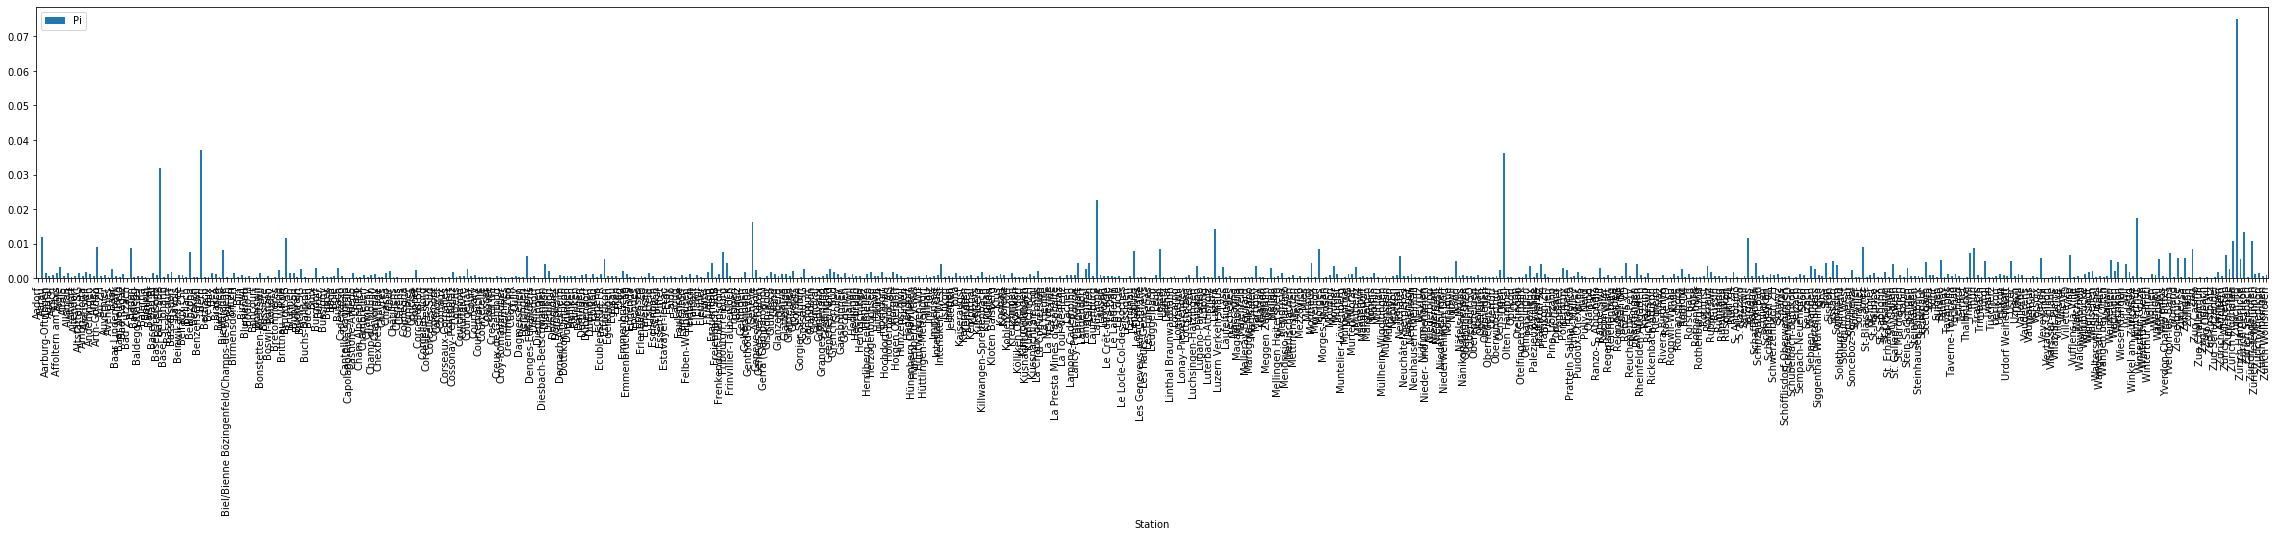

In [22]:
for steady in steady_states:
    steady.plot.bar(x='Station', y='Pi', figsize=(40, 5));

## Results

In [23]:
# Compute rankings
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank[['Station', 'Pi', 'Prob']]
    stationranks.append(stationrank)

In [24]:
# Day 1
stationranks[0]

Station        Pi      Prob
594           Zürich HB  0.074863  0.062355
44                 Bern  0.037215  0.019597
396               Olten  0.036189  0.034206
33            Basel SBB  0.031831  0.056832
286            Lausanne  0.022604  0.019063
..                  ...       ...       ...
149            Düdingen  0.000016  0.000000
196  Gerra (Gambarogno)  0.000014  0.000000
99             Colmegna  0.000011  0.001425
502  St. Gallen Winkeln  0.000006  0.000000
427         Rekingen AG -0.000000  0.000178

[603 rows x 3 columns]

## Network Visualization

In [25]:
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [26]:
TM = TMs[0]

In [27]:
# Construct the graph
G = nx.MultiDiGraph()
labels = {}
edge_labels = {}

for i, origin_state in enumerate(list(TM.index)):
    for j, destination_state in enumerate(list(TM.columns)):
        rate = TM.iloc[i, j]
        if rate > 0:
            G.add_edge(
                origin_state,
                destination_state,
                weight=rate,
                label="{:.02f}".format(rate))
            edge_labels[(origin_state,
                         destination_state)] = label = "{:.02f}".format(rate)

### Node attributes

In [28]:
bond = np.array(list(nx.get_edge_attributes(G,'weight').values()))

In [29]:
attrs = steady_states[0].set_index('Station').T.to_dict()

In [30]:
# Set pagerank metrics on each node,
nx.set_node_attributes(G, attrs)
pi = np.array(list(nx.get_node_attributes(G,'Pi').values()))

### Layout

In [31]:
pos = nx.spring_layout(G, seed=0)

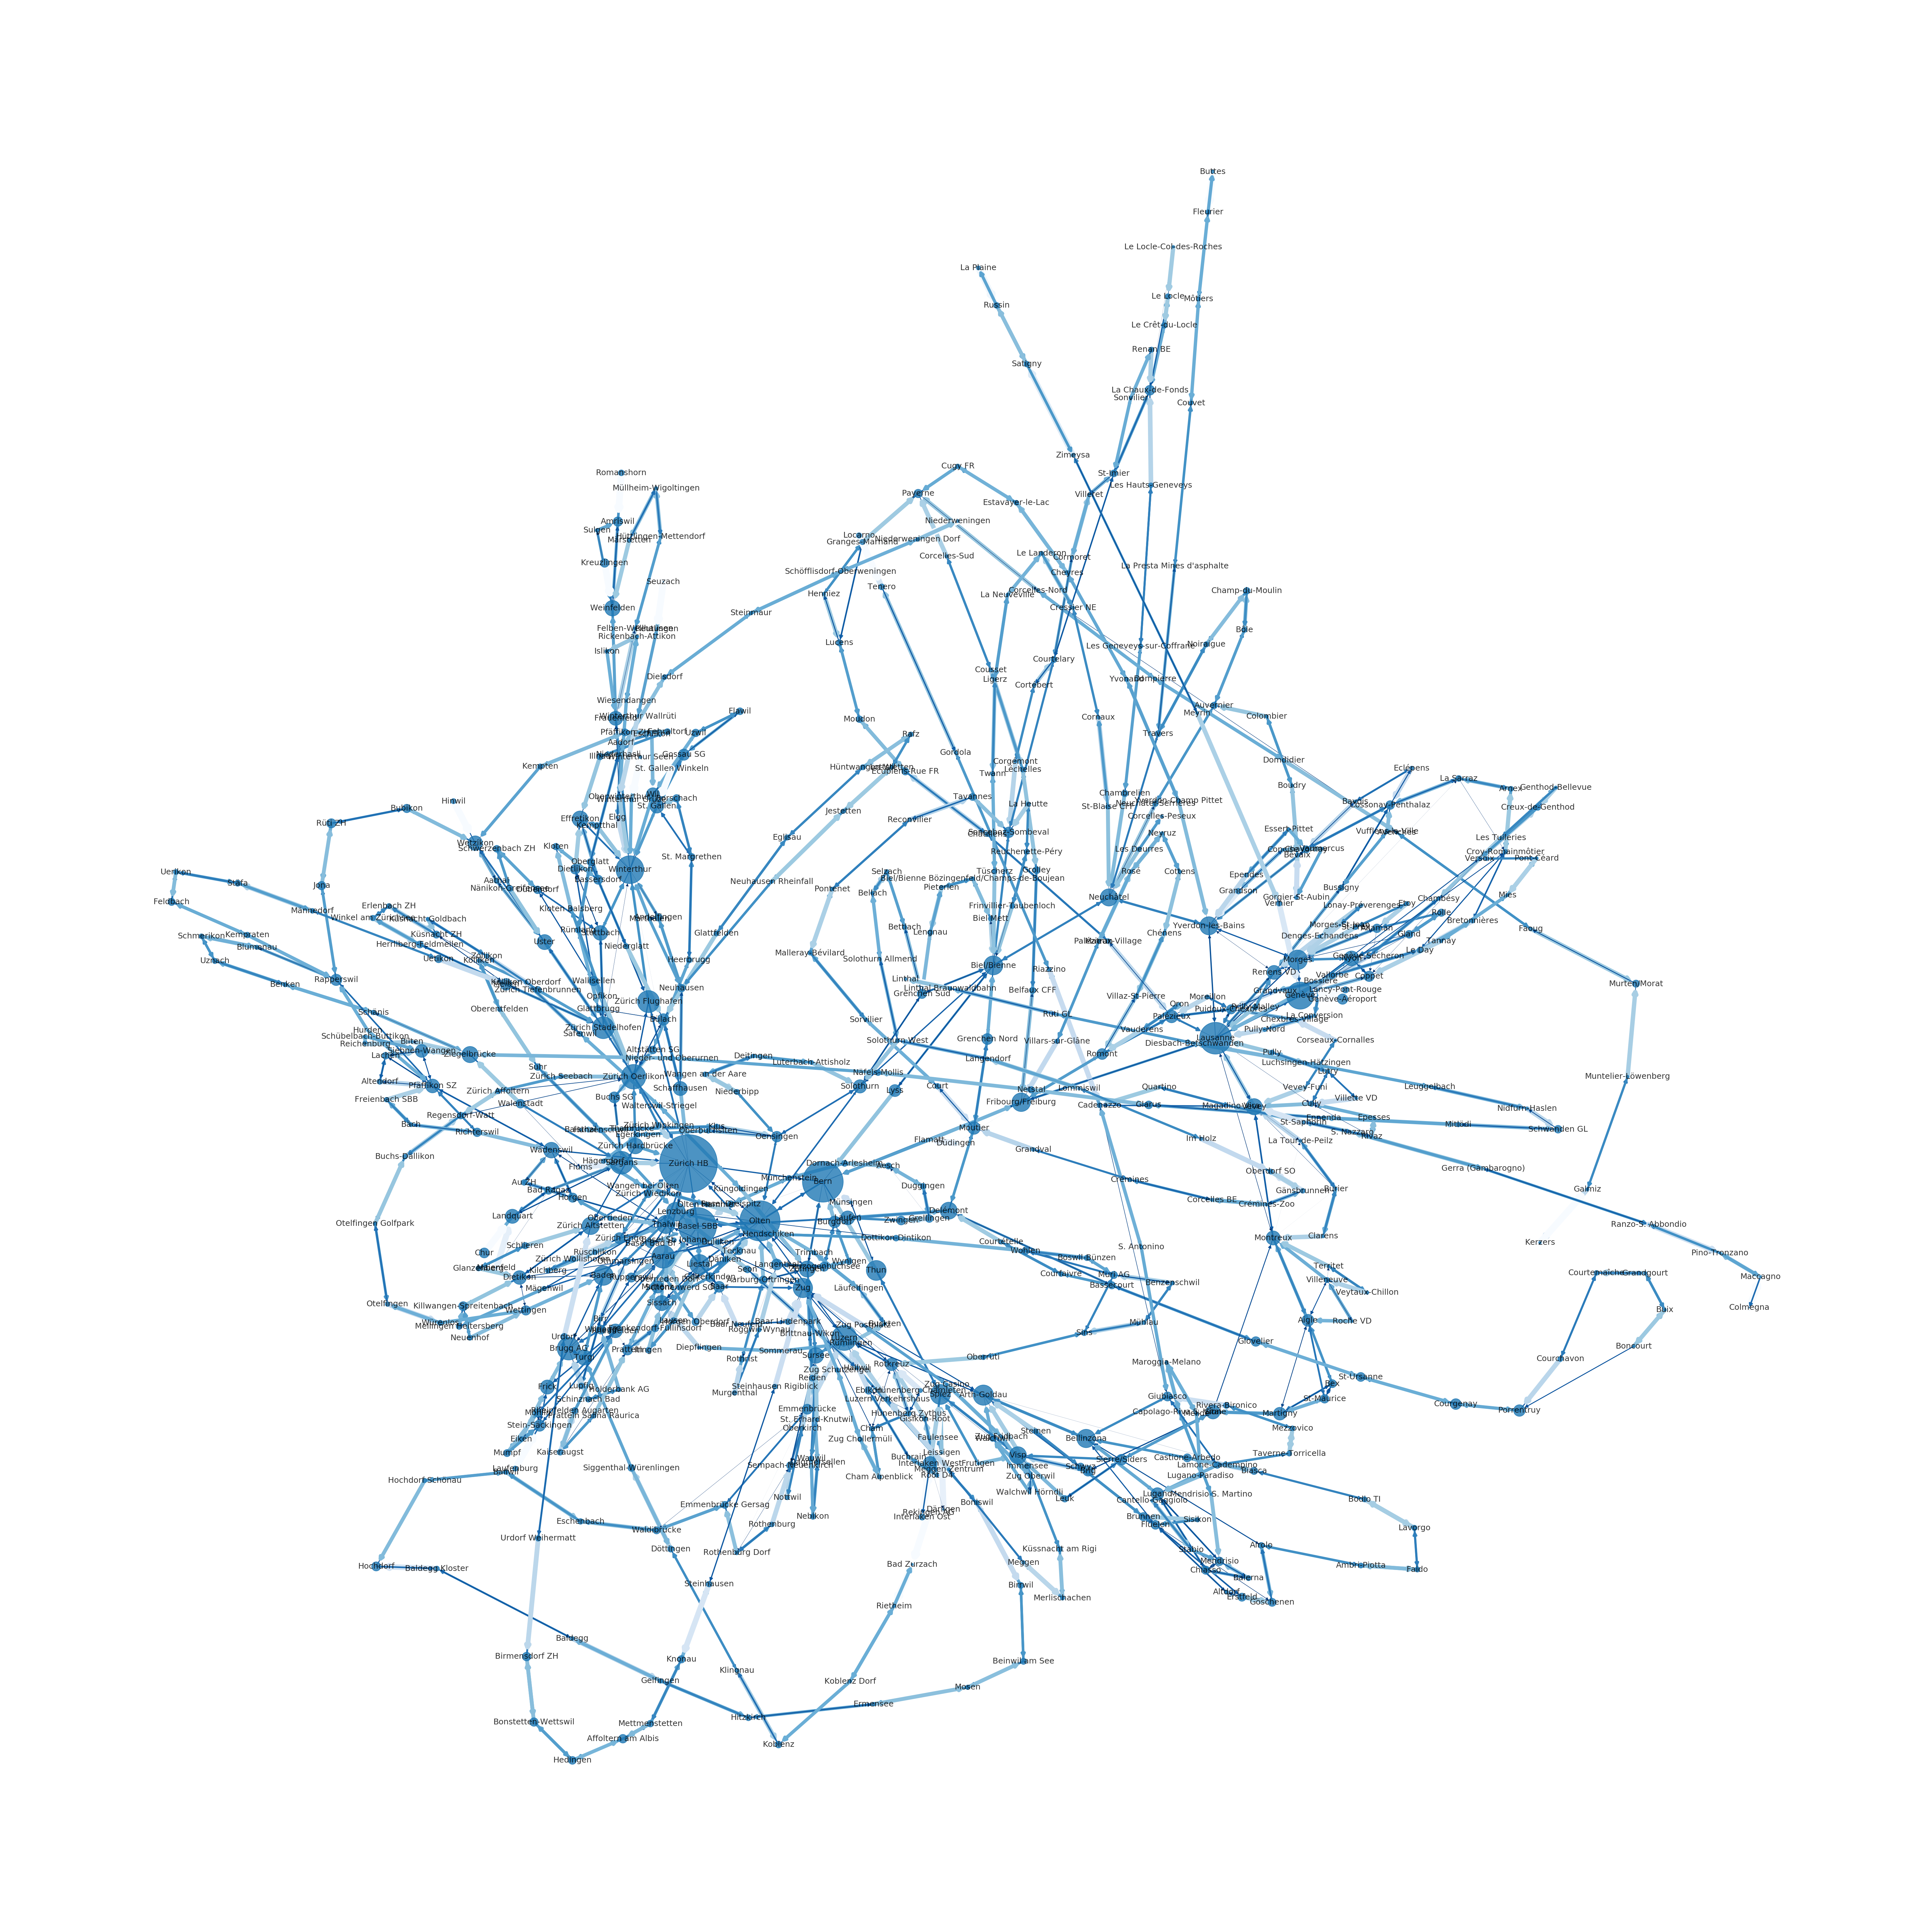

In [32]:
plt.figure(figsize = (40,40), dpi=150)
nx.draw(G, pos=pos, edge_color=bond,
        edge_cmap=plt.cm.Blues_r, with_labels=True, font_weight=2,
        node_size=pi*pow(10,5), width=bond*10, alpha=0.8)

## Export the Graph

In [37]:
# Write to file for further visualization
from networkx.drawing.nx_agraph import write_dot
import pygraphviz
write_dot(G, 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/sbb/Star5.png)